# A  Deep Learning Traffic Sign Recognition Classifier


## Load The Data

In [1]:
# Load pickled data
import pickle


training_file = "./trafficsignData/train.p"
testing_file = "./trafficsignData/test.p"

with open(training_file, mode='rb') as f:
    train = pickle.load(f)
with open(testing_file, mode='rb') as f:
    test = pickle.load(f)
    
X_train, y_train = train['features'], train['labels']
X_test, y_test = test['features'], test['labels']

import csv
names = {}
signames_dict = {}
with open('./signnames.csv', "rt") as csvfile:
    signames = csv.reader(csvfile, delimiter=',', quotechar='|')
    for row in signames:
        names[str(row[0])] = row[1]


## Dataset Summary & Exploration


In [2]:
#Global Information

n_train = len(X_train)

n_test = len(X_test)

image_shape = X_train[1].shape

n_classes = len(set(y_train))

print("Number of training examples =", n_train)
print("Number of testing examples =", n_test)
print("Image data shape =", image_shape)
print("Number of classes =", n_classes)

Number of training examples = 39209
Number of testing examples = 12630
Image data shape = (32, 32, 3)
Number of classes = 43


### Data exploration visualization

Right-of-way at the next intersection


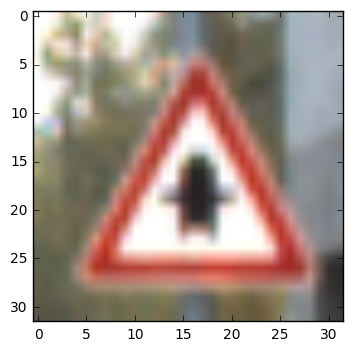

In [3]:
import matplotlib.pyplot as plt
import numpy as np
# Visualizations will be shown in the notebook.
%matplotlib inline

image_number1, image_number2 = 16926, 8034 

plt.imshow(X_train[image_number1])
print(names[str(y_train[image_number1])] )


Speed limit (70km/h)


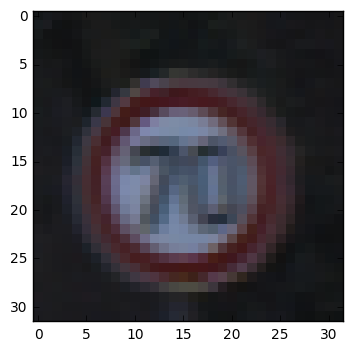

In [4]:
plt.imshow(X_train[image_number2], interpolation='nearest')
print(names[str(y_train[image_number2])] )

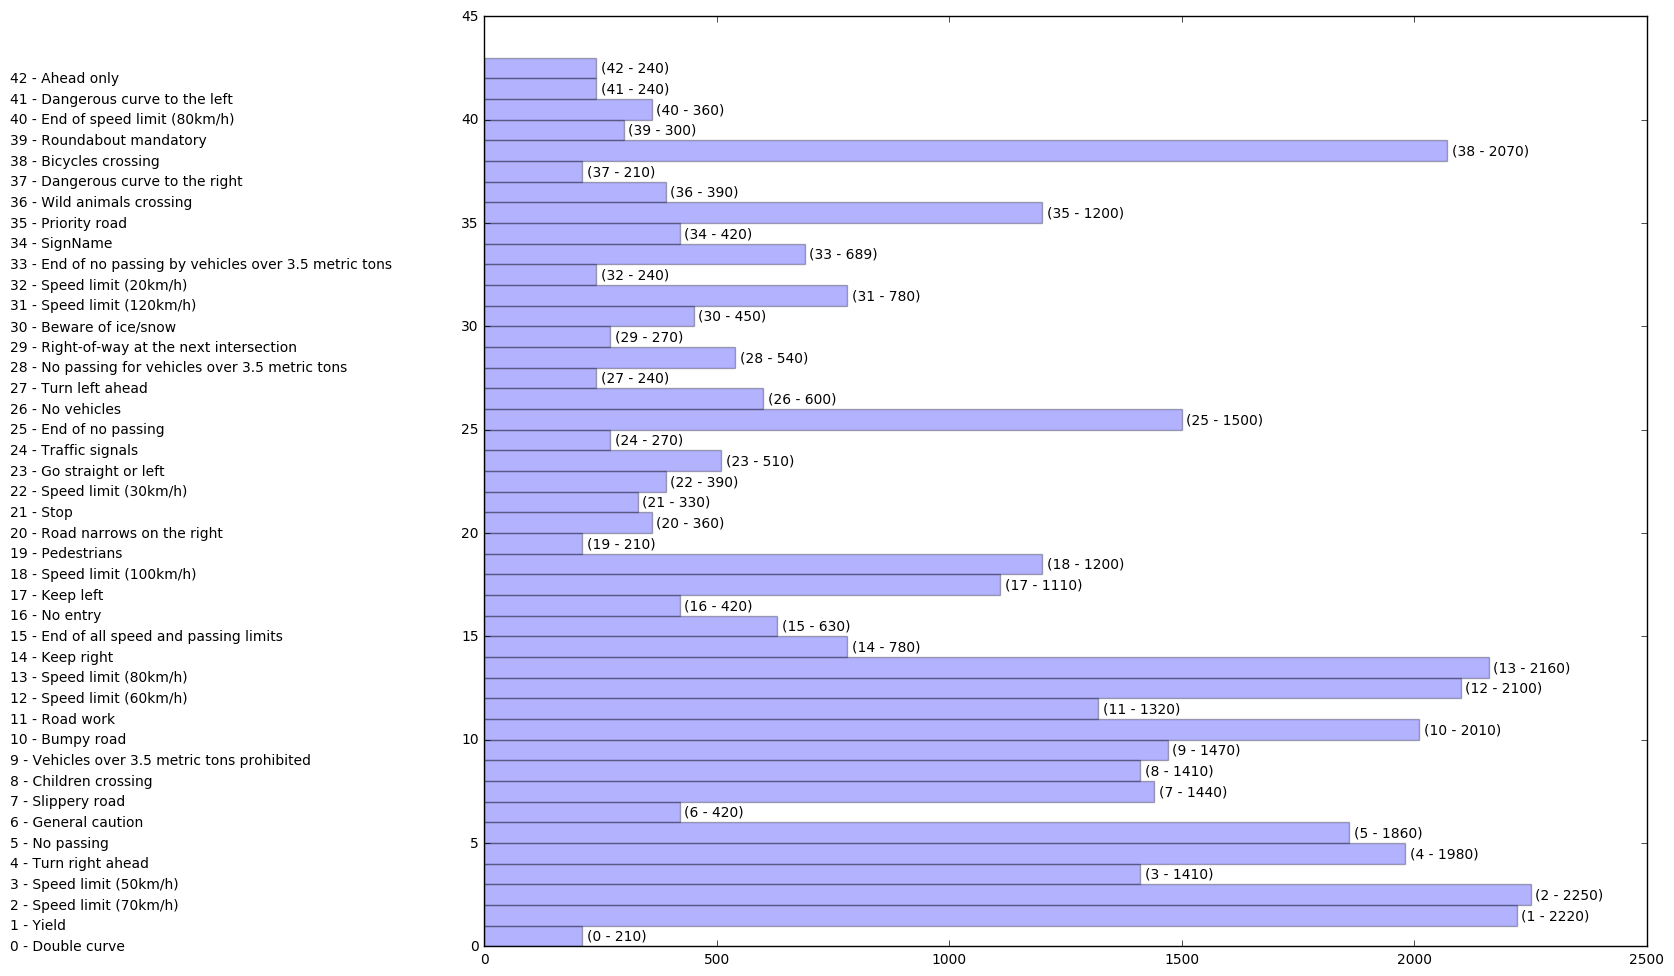

In [5]:
from itertools import groupby

def group_classes(Y):
    return {key:len(list(group)) for key, group in groupby(Y)}

def group_classes_sorted(Y):
    data = group_classes(Y)
    return sorted(data.items(), key=lambda x:x[1], reverse=True)


def plot_frequency(xlabel, xs, ys, with_names=True):
    fig, ax = plt.subplots(figsize=(15, 12))
    bars = ax.barh(xs, ys, 1, color='b', alpha=0.3)
    for i,bar in enumerate(bars):
        height = bar.get_y()
        if with_names:
            ax.text(bars[-1].get_width()-(bars[0].get_width()*6), height,
                '{} - {}'.format(i, xlabel[i]),rotation=0,ha='left', va='center')
        ax.text(bars[i].get_x()+bars[i].get_width()+10, height+bars[i].get_height()/2,
                '({} - {})'.format(i, ys[i]),rotation=0,ha='left', va='center')

plt.show()

data = group_classes(list(y_train))
plot_frequency(list(names.values()), np.array(list(set(y_train))), list(data.values()))

----

## Design a Model Architecture

### Data pre-processing

In [6]:
from random import randint
import numpy
from PIL import Image
from PIL import ImageChops

def upascale_train(x_train, y_train):
    '''
        argument new traingsdata with shifting and rotation
    
    '''
    y_train_new = np.empty([ len(x_train) * 5])
    newbatch = np.empty([ len(x_train) * 5 , 32, 32 , 3])
    
    newpos = 0

    for image in range(len(x_train)):
        nwebatch = x_train[image]
        # print(nwebatch)

        img = Image.fromarray(np.uint8(nwebatch))

        img3 = ImageChops.offset(img, randint(-2, 2) ,randint(-2, 2))
        img4 = ImageChops.offset(img, randint(-2, 2) ,randint(-2, 2))
        
        img = img.resize((1024, 1024), resample=Image.NEAREST)
        img = Image.Image.rotate(img, randint(0, 10))
        img2 = Image.Image.rotate(img, randint(-10, 0))
        img = img.resize((32, 32), resample=Image.NEAREST)
        img2 = img2.resize((32, 32), resample=Image.NEAREST)
        
                    
        backtonumpy = numpy.array(img)
        backtonumpy2 = numpy.array(img2)
        backtonumpy3 = numpy.array(img3)
        backtonumpy4 = numpy.array(img4)

        y_train_new[newpos] = y_train[image]
        newbatch[ newpos ] = x_train[image]
        newpos = newpos + 1
        y_train_new[newpos] = y_train[image]
        newbatch[ newpos ] = backtonumpy
        newpos = newpos + 1
        y_train_new[newpos] = y_train[image]
        newbatch[ newpos ] = backtonumpy2
        newpos = newpos + 1
        y_train_new[newpos] = y_train[image]
        newbatch[ newpos ] = backtonumpy3
        newpos = newpos + 1
        y_train_new[newpos] = y_train[image]
        newbatch[ newpos ] = backtonumpy4
        newpos = newpos + 1
        
            
    return newbatch , y_train_new

### Validation Split

In [7]:
from sklearn.utils import shuffle

def validation_set_split(X, Y):
    
    count = int(len(X)*.7)
    
    X, Y = shuffle(X, Y)

    X_train = X[:count]
    Y_train = Y[:count]

    X_val = X[count:]
    Y_val = Y[count:]

    return (X_train, Y_train, X_val, Y_val)

In [8]:
X_train, y_train, X_val, y_val = validation_set_split(X_train, y_train)

print("New Number of Validation Examples =", len(X_val))

#X_train, y_train = upascale_train(X_train, y_train)

print("New Number of Trainig Examples =", len(X_train))

New Number of Validation Examples = 11763
New Number of Trainig Examples = 27446


In [9]:
import tensorflow as tf
from tensorflow.contrib.layers import flatten


with tf.name_scope('OrginalImages'):
    x = tf.placeholder(tf.float32, (None, 32, 32, 3))
    
with tf.name_scope('Labels'):
    y = tf.placeholder(tf.int32, (None))
  
is_training = tf.placeholder(tf.bool, name='isTrainingBooleanBatch')
keep_prob = tf.placeholder(tf.float32, name='dropOutRate')
one_hot_y = tf.one_hot(y, 43, name='oneHotLabel')


with tf.device('/cpu:0'):
    tf.summary.image("OrginalImage", x)
    adjust = tf.image.random_brightness(x, 5)
    tf.summary.image("random_brightness", adjust)
    contrast = tf.image.random_contrast(adjust, 0.3, 1, seed=None)
    tf.summary.image("random_contrast", contrast)
    saturation = tf.map_fn(lambda img: tf.image.random_saturation(img, 0.1, 1, seed=None), contrast)
    tf.summary.image("random_saturation", saturation)

![title](./resnet.png)

In [10]:
def conv_3x3_relu_batch(input_x, shape_in, shape_out, scope, padding='SAME', max_pool=False , mu=0, sigma=0.1):
    
  
    with tf.variable_scope(scope):    
        weights = tf.get_variable("weights", initializer=tf.truncated_normal(shape=(3, 3, shape_in, shape_out), mean=mu, stddev=sigma))
        biases = tf.get_variable("biases", initializer=tf.zeros(shape_out))
        
        with tf.name_scope('convolution'):
            conv = tf.nn.conv2d(input_x, weights, strides=[1, 1, 1, 1], padding=padding)

        
        with tf.name_scope('relu'):
            relu = tf.nn.relu(conv + biases)
            
            
        with tf.name_scope('batch_norm'):
            batch_norm = tf.contrib.layers.batch_norm(relu, is_training=is_training)
        
        
        # this kills performance    
        # tf.summary.histogram('activations', relu)
        
        # this kills performance
        # tf.summary.histogram('pre_activations', batch_norm)

        # with tf.name_scope('dropout'):
        #    dropout= tf.nn.dropout(relu, keep_prob)
        
        if (max_pool):
            with tf.name_scope('max_pool_2x2'):
                pool = tf.nn.max_pool(batch_norm, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='VALID')
            return pool
        else:
            return batch_norm


In [11]:
def logits_net(x, mu=0, sigma=0.1):

    with tf.name_scope('1_conv_block'):
        conv_1 = conv_3x3_relu_batch(x      , 3 , 64, "conv1")
        conv_2 = conv_3x3_relu_batch(conv_1 , 64 , 64, "conv2", padding='VALID')
       
    with tf.name_scope('2_conv_block'):
        conv_3 = conv_3x3_relu_batch(conv_2 , 64 , 128 , "conv3")
        conv_4 = conv_3x3_relu_batch(conv_3 , 128 , 128 , "conv4" , padding='VALID')
    
    
    with tf.name_scope('3_conv_block'):
        conv_5 = conv_3x3_relu_batch(conv_4 , 128 , 256 , "conv5")
        conv_6 = conv_3x3_relu_batch(conv_5 , 256 , 256 , "conv6", padding='VALID')
        conv_7 = conv_3x3_relu_batch(conv_6 , 256 , 256 , "conv7")
        conv_8 = conv_3x3_relu_batch(conv_7 , 256 , 256 , "conv8" , max_pool=True)
        
    with tf.name_scope('4_conv_block'):
        conv_9 = conv_3x3_relu_batch(conv_8 , 256 , 512 , "conv9")
        conv_10 = conv_3x3_relu_batch(conv_9 , 512 , 512 , "conv10", padding='VALID')
        conv_11 = conv_3x3_relu_batch(conv_10 , 512 , 512 , "conv11")
        conv_12 = conv_3x3_relu_batch(conv_11 , 512 , 512 , "conv12" , max_pool=True)
                
    with tf.name_scope('5_conv_block'):
        conv_13 = conv_3x3_relu_batch(conv_12 , 512 , 1024 , "conv13")
        conv_14 = conv_3x3_relu_batch(conv_13 , 1024 , 1024 , "conv14", padding='VALID')
        conv_15 = conv_3x3_relu_batch(conv_14 , 1024 , 1024 , "conv15")
        conv_16 = conv_3x3_relu_batch(conv_15 , 1024 , 1024 , "conv16" , max_pool=True)

    fc0 = flatten(conv_16)


    with tf.name_scope('1_fully_connected'):
        fc1_W = tf.Variable(tf.truncated_normal(shape=(1024, 256), mean=mu, stddev=sigma))
        fc1_b = tf.Variable(tf.zeros(256))
        fc1 = tf.matmul(fc0, fc1_W) + fc1_b        
        fc1 = tf.nn.relu(fc1)       
        fc1_drop = tf.nn.dropout(fc1, keep_prob)

    with tf.name_scope('2_fully_connected'):
        fc2_W = tf.Variable(tf.truncated_normal(shape=(256, 43), mean=mu, stddev=sigma))
        fc2_b = tf.Variable(tf.zeros(43))
        
        
    logits = tf.matmul(fc1_drop, fc2_W) + fc2_b
    
    return logits

In [12]:
rate = 0.0001

logits = logits_net(x)

with tf.name_scope('train'):
    cross_entropy = tf.nn.softmax_cross_entropy_with_logits(logits, one_hot_y)
    loss_operation = tf.reduce_mean(cross_entropy)

    optimizer = tf.train.AdamOptimizer(learning_rate=rate)
    training_operation = optimizer.minimize(loss_operation)

tf.summary.scalar('loss', loss_operation)

correct_prediction = tf.equal(tf.argmax(logits, 1), tf.argmax(one_hot_y, 1))
accuracy_operation = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

tf.summary.scalar('accuracy', accuracy_operation)

test = tf.argmax(logits, 1)
saver = tf.train.Saver()

In [13]:
EPOCHS = 5
BATCH_SIZE = 128

def evaluate(X_data, y_data):
    num_examples = len(X_data)
    total_accuracy = 0
    sess = tf.get_default_session()
    for offset in range(0, num_examples, BATCH_SIZE):
        batch_x, batch_y = X_data[offset:offset + BATCH_SIZE], y_data[offset:offset + BATCH_SIZE]
        accuracy = sess.run(accuracy_operation, feed_dict={x:  batch_x, y: batch_y, keep_prob: 1.0, is_training: True})
        total_accuracy += (accuracy * len(batch_x))
    return total_accuracy / num_examples

## Training

In [ ]:
with tf.Session() as sess:

   
    sess.run(tf.global_variables_initializer())
    num_examples = len(X_train)
    
    
    merged = tf.summary.merge_all()
    
    # run tensorboard --logdir=/home/sven/trafficnetsave/train  
    # for Tensorboard
    
    train_writer = tf.summary.FileWriter('/home/sven/trafficnetsave/train', sess.graph)
    test_writer = tf.summary.FileWriter('/home/sven/trafficnetsave/test')
    tf.global_variables_initializer().run()

    epoch_start = 1
   
    # saver.restore(sess, '/home/sven/trafficnetsave/resnet')
    print("Training...")
    for i in enumerate(range(epoch_start, EPOCHS), 1):
        X_train, y_train = shuffle(X_train, y_train)
        for offset in range(0, num_examples, BATCH_SIZE):
            end = offset + BATCH_SIZE
            batch_x, batch_y = X_train[offset:end], y_train[offset:end]
            feed_dict={x: saturation.eval(feed_dict={x: batch_x}), y: batch_y, keep_prob: 0.5 , is_training: True}
            summary , _, loss_val = sess.run([merged , training_operation, loss_operation], feed_dict )

        validation_accuracy = evaluate(X_val, y_val)
        print("EPOCH {} ...".format(i[0]))
        print("Validation Accuracy = {:.3f}".format(validation_accuracy))
        print()

        train_writer.add_summary(summary, i[0])

        #save_path = saver.save(sess, '/home/sven/trafficnetsave/resnet/batch', global_step=i[0])
        #print("Model saved : %s" % i)
    

## Results

In [14]:
with tf.Session() as sess:
    saver.restore(sess, '/home/sven/trafficnetsave/resnet/batch-57')
    validation_accuracy = evaluate(X_test, y_test)
    print("Test Accuracy = {:.3f}%".format(validation_accuracy * 100))

Test Accuracy = 98.860%


In [21]:
def get_result(test_image_number, get_top = 5):
    plt.imshow(X_test[test_image_number])
    print("Korrekt:", names[str(y_test[test_image_number])] )

    top_five = tf.nn.top_k(logits, k=get_top, sorted=True, name=None)

    with tf.Session() as sess:
        saver.restore(sess, '/home/sven/trafficnetsave/resnet/batch-57')
        f = X_test[test_image_number:test_image_number+1]
        top_five = sess.run(top_five, feed_dict={x: f, keep_prob: 1.0, is_training: True})


    ergebnisse = {}

    for i in range(0,get_top):
        ergebnisse [top_five[0][0][i]] = names[str(top_five[1][0][i])]

    print("\n".join("{}: {}".format(k, v) for k, v in ergebnisse.items()))


### korrekte prediction

Korrekt: No passing
0.966901957988739: Priority road
0.19029709696769714: Bumpy road
2.522153615951538: Keep right
2.444779634475708: No passing for vehicles over 3.5 metric tons
7.2521209716796875: No passing


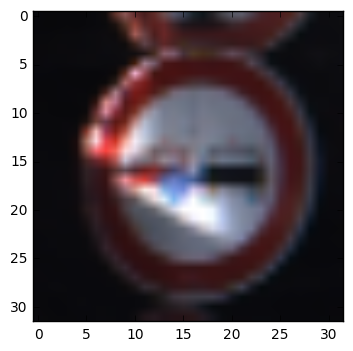

In [17]:
get_result(450)

Korrekt: Speed limit (70km/h)
0.7136529088020325: Speed limit (120km/h)
9.075693130493164: Speed limit (70km/h)
2.8517005443573: No passing for vehicles over 3.5 metric tons
4.669802665710449: Speed limit (20km/h)
0.5670320987701416: Speed limit (80km/h)


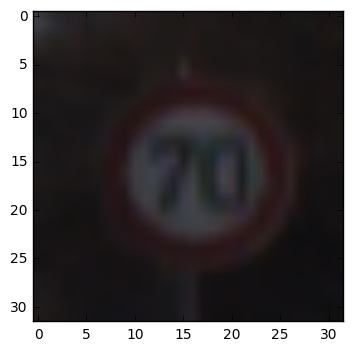

In [19]:
get_result(20)

Korrekt: Pedestrians
0.7984701991081238: Traffic signals
1.2958916425704956: Speed limit (50km/h)
2.8741981983184814: Right-of-way at the next intersection
3.853618621826172: Pedestrians
0.6005386114120483: Speed limit (30km/h)


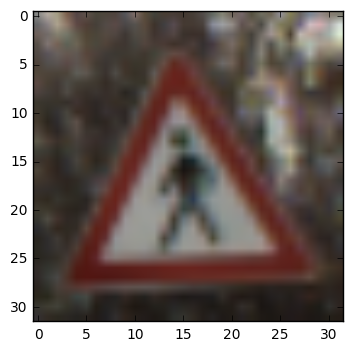

In [20]:
get_result(10000)

### inkorrekt

Korrekt: No entry
8.308388710021973: No entry
9.044358253479004: No passing
3.1516575813293457: Keep right
0.8092354536056519: End of no passing
1.7583757638931274: Stop


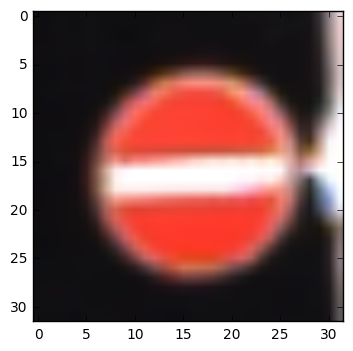

In [23]:
get_result(35)